In [2]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("date_promovare_examen.csv")
print(data.head())


   Ore_Studiu  Ore_Somn  Promovare
0        6.50      8.46          1
1        5.86      8.95          1
2        6.65      7.30          1
3        7.52      8.28          1
4        5.77      7.67          1


Promovare
1    0.5
0    0.5
Name: proportion, dtype: float64


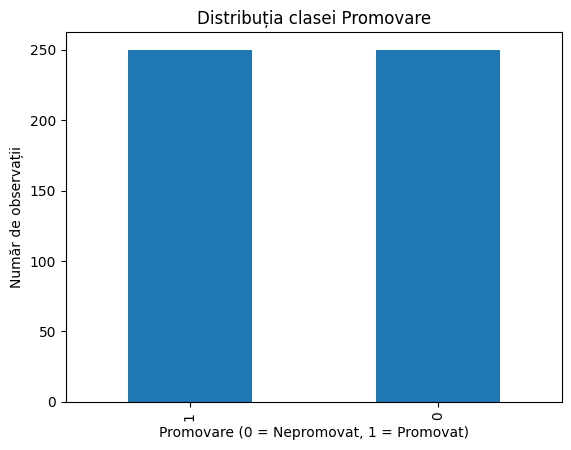

In [26]:

print(data['Promovare'].value_counts(normalize=True))

data['Promovare'].value_counts().plot(kind='bar')
plt.title('Distribuția clasei Promovare')
plt.xlabel('Promovare (0 = Nepromovat, 1 = Promovat)')
plt.ylabel('Număr de observații')
plt.show()


In [5]:
X = data[['Ore_Studiu', 'Ore_Somn']]
y = data['Promovare']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ore_studiu = X_scaled[:, 0]
ore_somn = X_scaled[:, 1]

In [ ]:
with pm.Model() as logistic_model:

    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta_studiu = pm.Normal('beta_studiu', mu=0, sigma=1)
    beta_somn = pm.Normal('beta_somn', mu=0, sigma=1)
    p = pm.math.sigmoid(alpha + beta_studiu * ore_studiu + beta_somn * ore_somn)
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y)
    trace = pm.sample(2000, tune=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_studiu, beta_somn]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.


In [10]:
az.summary(trace, var_names=['alpha', 'beta_studiu', 'beta_somn'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.094,0.434,-0.711,0.919,0.006,0.005,4673.0,4454.0,1.0
beta_studiu,2.731,0.650,1.525,3.987,0.009,0.006,5534.0,5163.0,1.0
beta_somn,3.579,0.603,2.415,4.682,0.008,0.006,5808.0,5163.0,1.0


In [17]:
#print(trace["posterior"])

alpha_mean = float(trace.posterior['alpha'].mean())
beta_studiu_mean = float(trace.posterior['beta_studiu'].mean())
beta_somn_mean = float(trace.posterior['beta_somn'].mean())

print(f"Alpha: {alpha_mean:.2f}, Beta Studiu: {beta_studiu_mean:.2f}, Beta Somn: {beta_somn_mean:.2f}")

Alpha: 0.09, Beta Studiu: 2.73, Beta Somn: 3.58


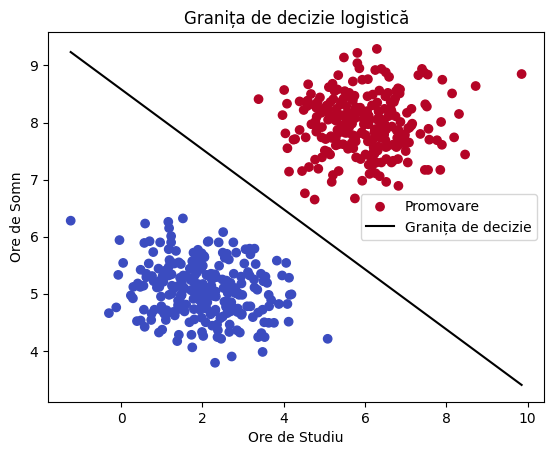

In [27]:
x_vals = np.linspace(data['Ore_Studiu'].min(), data['Ore_Studiu'].max(), 100)
y_vals = -(alpha_mean + beta_studiu_mean * (x_vals - data['Ore_Studiu'].mean()) / data['Ore_Studiu'].std()) / (beta_somn_mean / data['Ore_Somn'].std()) + data['Ore_Somn'].mean()

plt.scatter(data['Ore_Studiu'], data['Ore_Somn'], c=y, cmap='coolwarm', label='Promovare')
plt.plot(x_vals, y_vals, color='black', label='Granița de decizie')
plt.xlabel('Ore de Studiu')
plt.ylabel('Ore de Somn')
plt.legend()
plt.title('Granița de decizie logistică')
plt.show()

In [24]:
beta_studiu_samples = float(trace.posterior['beta_studiu'].mean())
beta_somn_samples = float(trace.posterior['beta_somn'].mean())

print(f"Influență medie - Beta Studiu: {beta_studiu_samples}")
print(f"Influență medie - Beta Somn: {beta_somn_samples}")

Influență medie - Beta Studiu: 2.730946253662724
Influență medie - Beta Somn: 3.579377513540499
